In [29]:
import math
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque 
import random
import matplotlib.pyplot as plt
import pandas as pd

from model import HDDriveDQN, HDMapSensorDQN, hd_net_args, HDMapSensorDQN_V0, HDDriveDQN_V0_GRU

from agent import MemoryBufferSimple, DQN_Agent, MemoryBufferSeparated
import random
import itertools
from srunner.tools import dotdict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
stats = {
'category':['straight','curved'],
'type': ['s1','c1'],
'name': ['sok','cok'],
'collisionCount': [7,9],
'wrongLaneCount': [5,0],
'outsideDrivingLanesCount': [3,0],
'offRoadCount': [0,152],
'routeCompletionPer': [1,2]
}
stats

{'category': ['straight', 'curved'],
 'type': ['s1', 'c1'],
 'name': ['sok', 'cok'],
 'collisionCount': [7, 9],
 'wrongLaneCount': [5, 0],
 'outsideDrivingLanesCount': [3, 0],
 'offRoadCount': [0, 152],
 'routeCompletionPer': [1, 2]}

In [70]:
df_stats = pd.DataFrame(stats)
df_stats.index = pd.Index(range(len(df_stats)), name='idx')
df_stats.to_csv('eval_stats.csv')
df_stats

,category,type,name,collisionCount,wrongLaneCount,outsideDrivingLanesCount,offRoadCount,routeCompletionPer
idx,,,,,,,,
0,straight,s1,sok,7,5,3,0,1
1,curved,c1,cok,9,0,0,152,2


In [73]:
df_ok_stats = pd.read_csv('eval_stats_HDDriveDQN_V0_GRU_8f_Trueres_LEG2_CURVED.csv')

In [74]:
df_ok_stats.set_index('idx', inplace=True)
df_ok_stats

,category,type,name,collisionCount,wrongLaneCount,outsideDrivingLanesCount,offRoadCount,routeCompletionPer
idx,,,,,,,,
0,straight,straight,PTESTStraight_1,1,1,1,1,75.470369
1,straight,straight,PTESTStraight_2,0,0,0,1,85.553012
2,curved,left_curved,TESTLeftCurved_1,0,0,0,0,75.904912
3,curved,left_curved,TESTLeftCurved_2,4,0,0,2,96.430281
4,curved,right_curved,TESTRightCurved_1,0,1,1,1,100.000000
5,curved,right_curved,TESTRightCurved_2,1,1,1,1,60.781898


In [24]:
steering_space = [-1,-0.825,-0.75,-0.625,-0.5,-0.375,-0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.825, 1]
throttle_space = [0, 0.5, 1]
brake_space = [0, 0.5, 1]
actions = []
for s in steering_space:
    for t in throttle_space:
        for b in brake_space:
            if t == 0:
                actions.append([s, 0, b])
            elif b == 0:
                actions.append([s, t, 0])
acts = np.array(actions)
len(actions), acts.shape

(85, (85, 3))

In [25]:
action_space = hd_net_args.action_space 
space_2_idx = {tuple(act):idx for idx, act in enumerate(actions)}

In [26]:
acts = [  [ 0.,     0.,     0.,   ], [-0.825,  0.,     0.   ], [-0.75,   0.,     0.   ], [-0.625,  0.,     0.   ], 
                                [-1.,     0.,     0.5,  ], [-0.825,  0.,     0.5  ], [-0.75,   0.,     0.5  ], [-0.625,  0.,     0.5  ],
                                [-1.,     0.,     1.,   ], [-0.825,  0.,     1.   ], [-0.75,   0.,     1.   ], [-0.625,  0.,     1.   ],
                                [-1.,     0.5,    0.,   ], [-0.825,  0.5,    0.   ], [-0.75,   0.5,    0.   ], [-0.625,  0.5,    0.   ],
                                [-1.,     1.,     0.,   ], [-0.825,  1.,     0.   ], [-0.75,   1.,     0.   ], [-0.625,  1.,     0.   ],
                                
                                [-0.5,    0.,     0.   ], [-0.375,  0.,     0.   ], [-0.25,   0.,     0.   ], [-0.125,  0.,     0.   ], 
                                [-0.5,    0.,     0.5  ], [-0.375,  0.,     0.5  ], [-0.25,   0.,     0.5  ], [-0.125,  0.,     0.5  ],
                                [-0.5,    0.,     1.   ], [-0.375,  0.,     1.   ], [-0.25,   0.,     1.   ], [-0.125,  0.,     1.   ],
                                [-0.5,    0.5,    0.   ], [-0.375,  0.5,    0.   ], [-0.25,   0.5,    0.   ], [-0.125,  0.5,    0.   ],
                                [-0.5,    1.,     0.   ], [-0.375,  1.,     0.   ], [-0.25,   1.,     0.   ], [-0.125,  1.,     0.   ],
                                
                                [-1.,     0.,     0.   ], [ 0.125,  0.,     0.   ], [ 0.25,   0.,     0.   ], [ 0.375,  0.,     0.   ],  
                                [ 0.,     0.,     0.5  ], [ 0.125,  0.,     0.5  ], [ 0.25,   0.,     0.5  ], [ 0.375,  0.,     0.5  ],  
                                [ 0.,     0.,     1.   ], [ 0.125,  0.,     1.   ], [ 0.25,   0.,     1.   ], [ 0.375,  0.,     1.   ],  
                                [ 0,     0.5,     0.   ], [ 0.125,  0.5,    0.   ], [ 0.25,   0.5,    0.   ], [ 0.375,  0.5,    0.   ],  
                                [ 0.,     1.,     0.   ], [ 0.125,  1.,     0.   ], [ 0.25,   1.,     0.   ], [ 0.375,  1.,     0.   ],  

                                [ 0.5,    0.,     0.   ], [ 0.625,  0.,     0.   ], [ 0.75,   0.,     0.   ], [ 0.825,  0.,     0.   ], 
                                [ 0.5,    0.,     0.5  ], [ 0.625,  0.,     0.5  ], [ 0.75,   0.,     0.5  ], [ 0.825,  0.,     0.5  ],
                                [ 0.5,    0.,     1.   ], [ 0.625,  0.,     1.   ], [ 0.75,   0.,     1.   ], [ 0.825,  0.,     1.   ],
                                [ 0.5,    0.5,    0.   ], [ 0.625,  0.5,    0.   ], [ 0.75,   0.5,    0.   ], [ 0.825,  0.5,    0.   ],
                                [ 0.5,    1.,     0.   ], [ 0.625,  1.,     0.   ], [ 0.75,   1.,     0.   ], [ 0.825,  1.,     0.   ],  

                                [ 1.,     0.,     0.   ],
                                [ 1.,     0.,     0.5  ],
                                [ 1.,     0.,     1.   ],
                                [ 1.,     0.5,    0.   ],
                                [ 1.,     1.,     0.   ]]
space_2_idx = {tuple(act):idx for idx, act in enumerate(acts)}

In [27]:
space_2_idx

{(0.0, 0.0, 0.0): 0,
 (-0.825, 0.0, 0.0): 1,
 (-0.75, 0.0, 0.0): 2,
 (-0.625, 0.0, 0.0): 3,
 (-1.0, 0.0, 0.5): 4,
 (-0.825, 0.0, 0.5): 5,
 (-0.75, 0.0, 0.5): 6,
 (-0.625, 0.0, 0.5): 7,
 (-1.0, 0.0, 1.0): 8,
 (-0.825, 0.0, 1.0): 9,
 (-0.75, 0.0, 1.0): 10,
 (-0.625, 0.0, 1.0): 11,
 (-1.0, 0.5, 0.0): 12,
 (-0.825, 0.5, 0.0): 13,
 (-0.75, 0.5, 0.0): 14,
 (-0.625, 0.5, 0.0): 15,
 (-1.0, 1.0, 0.0): 16,
 (-0.825, 1.0, 0.0): 17,
 (-0.75, 1.0, 0.0): 18,
 (-0.625, 1.0, 0.0): 19,
 (-0.5, 0.0, 0.0): 20,
 (-0.375, 0.0, 0.0): 21,
 (-0.25, 0.0, 0.0): 22,
 (-0.125, 0.0, 0.0): 23,
 (-0.5, 0.0, 0.5): 24,
 (-0.375, 0.0, 0.5): 25,
 (-0.25, 0.0, 0.5): 26,
 (-0.125, 0.0, 0.5): 27,
 (-0.5, 0.0, 1.0): 28,
 (-0.375, 0.0, 1.0): 29,
 (-0.25, 0.0, 1.0): 30,
 (-0.125, 0.0, 1.0): 31,
 (-0.5, 0.5, 0.0): 32,
 (-0.375, 0.5, 0.0): 33,
 (-0.25, 0.5, 0.0): 34,
 (-0.125, 0.5, 0.0): 35,
 (-0.5, 1.0, 0.0): 36,
 (-0.375, 1.0, 0.0): 37,
 (-0.25, 1.0, 0.0): 38,
 (-0.125, 1.0, 0.0): 39,
 (-1.0, 0.0, 0.0): 40,
 (0.125, 0.0, 0.0)

In [15]:
def real_to_space_idx(space, val, delta):
    idx = len(space)-1
    for i in range(len(space)):
            if val - delta < space[i]:
                idx = i 
                break
    return idx

In [16]:
idx = real_to_space_idx(brake_space, 0.5, 0.5/2)
brake_space[idx]

0.5

In [22]:
act = {'steer':0.6, 'throttle':0, 'brake': 1}
brake_space = throttle_space
steer_delta = 0.2/2
delta = 0.1/2

def act_to_discrete(act, steering_space, throttle_space, brake_space,
                    steer_delta, delta, space_2_idx):
    throttle_used = True if act['throttle'] > 0 else False 
        
    steering_idx = real_to_space_idx(steering_space, act['steer'], steer_delta)
    steer_val = steering_space[steering_idx]
    if throttle_used:
        throttle_idx = real_to_space_idx(throttle_space, act['throttle'], delta)
        throttle_val = throttle_space[throttle_idx]
        brake_val = 0
    else: 
        brake_idx = real_to_space_idx(brake_space, act['brake'], delta)
        brake_val = brake_space[brake_idx]
        throttle_val = 0
    sep_space_idxs = (steer_val, throttle_val, brake_val)
    return space_2_idx[sep_space_idxs]
disc_idx = act_to_discrete(act, steering_space, throttle_space, 
                brake_space, 0.125/2, 0.5/2, space_2_idx)
acts[disc_idx], disc_idx

([0.625, 0.0, 1.0], 69)

In [138]:
idx = real_to_space_idx(throttle_space, 0.1, delta)
idx, throttle_space[idx]

(1, 0.1)

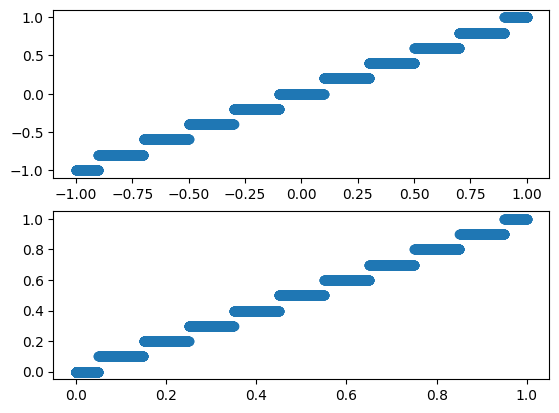

In [139]:
fig, ax = plt.subplots(2)
ax[0].scatter(steer_x, steer_val)
ax[1].scatter(throttle_x, throttle_val)
# plt.scatter(x=steer_x, y=steer_val)

In [6]:
with open('state.pickle', 'rb') as fp:
    state = pickle.load(fp)
state.keys()

dict_keys(['frame', 'accelerometer', 'gyroscope', 'compass', 'gnss', 'velocity', 'hd_map', 'front_sem'])

In [7]:
h_size = 128
hd_net_args.device = 'cpu'
hd_sensor_model = HDMapSensorDQN_V0((3,96,96), 7, hd_net_args, p=0.3)
npImg_to_tensor = lambda x: torch.tensor(np.expand_dims(x.transpose(2,0,1), axis=0), dtype=torch.float32)

In [8]:
acc_X = torch.tensor(state['accelerometer'], dtype=torch.float32).unsqueeze(0)
comp_X = torch.tensor(state['compass'], dtype=torch.float32).unsqueeze(0)
gyro_X = torch.tensor(state['gyroscope'], dtype=torch.float32).unsqueeze(0)
bev_X = npImg_to_tensor(state['hd_map'])
front_X = npImg_to_tensor(state['front_sem'])
vel_X = torch.tensor(state['velocity']).unsqueeze(0)
bev_X.shape, front_X.shape, acc_X.shape, gyro_X.shape, comp_X.shape, vel_X.shape

(torch.Size([1, 3, 96, 96]),
 torch.Size([1, 3, 96, 96]),
 torch.Size([1, 3]),
 torch.Size([1, 3]),
 torch.Size([1, 1]),
 torch.Size([1]))

In [9]:
state_h = hd_sensor_model(bev_X.repeat(32,1,1,1), front_X.repeat(32,1,1,1), acc_X.repeat(32,1), comp_X.repeat(32,1), gyro_X.repeat(32,1), vel_X.repeat(32))
state_h.shape

torch.Size([32, 384])

In [10]:
X = torch.rand(16,32,128)
n = nn.Linear(128, 128)

In [11]:
ts = []
for t in X:
    ts.append(n(t))
ts = torch.stack(ts, dim=0)
ts.shape, n(X).shape, (ts==n(X)).all()

(torch.Size([16, 32, 128]), torch.Size([16, 32, 128]), tensor(False))

In [12]:
ts = []
for i in range(len(X)):
    ts.append(n(X[i]))
ts = torch.stack(ts, dim=0)
all_once = n(X)
all_smart = n(X.transpose(0,1).reshape(-1,128)).reshape(32,16,128).transpose(0,1)
ts.shape, n(X).shape, torch.allclose(ts, all_once, atol=1e-6), torch.allclose(ts, all_smart, atol=1e-6), (all_once==all_smart).all()

(torch.Size([16, 32, 128]),
 torch.Size([16, 32, 128]),
 True,
 True,
 tensor(True))

In [17]:
args = hd_net_args
args.device = 'cpu'
hd_drive_net = HDDriveDQN_V0_GRU(args)

In [18]:
bev_X.repeat(4,32,1,1,1).shape, vel_X.shape

(torch.Size([4, 32, 3, 96, 96]), torch.Size([1]))

In [31]:
hd_drive_net.eval()
q_vals = hd_drive_net(bev_X.repeat(args.n_frames,32,1,1,1), 
             front_X.repeat(args.n_frames, 32,1,1,1), 
             acc_X.repeat(args.n_frames, 32,1), 
             comp_X.repeat(args.n_frames, 32,1), 
             gyro_X.repeat(args.n_frames, 32,1), 
             vel_X.repeat(args.n_frames, 32),
             torch.zeros(args.n_frames, 32, dtype=torch.long))
q_vals.shape

torch.Size([32, 31])

In [29]:
q_vals[0]

tensor([ 0.2357, -0.0686, -0.1893, -0.2140, -0.1421, -0.1445,  0.1060, -0.2821,
        -0.0764, -0.1688,  0.0761, -0.1019,  0.0298,  0.5027,  0.3850, -0.1797,
        -0.5263,  0.1358,  0.2195,  0.0369,  0.0747,  0.2953, -0.0650,  0.0681,
        -0.0078,  0.2483, -0.4273, -0.0918, -0.2208,  0.3533,  0.2650],
       grad_fn=<SelectBackward0>)

In [18]:
nn.Embedding(35, 128)

Embedding(35, 128)

In [19]:
torch.arange(10,device='cpu')

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
x = torch.tensor([[1,2,3],[4,5,6]])
x.shape,x

(torch.Size([2, 3]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

In [21]:
x.unsqueeze(1).repeat(1,32,1)[0,0,:] == x[0]

tensor([True, True, True])

In [22]:
emb = nn.Embedding(35, 128)
e = emb(torch.arange(35,device='cpu'))
bacth_e = emb(torch.arange(35,device='cpu')).unsqueeze(1).repeat(1,32,1)
bacth_e.shape, e.shape

(torch.Size([35, 32, 128]), torch.Size([35, 128]))

In [23]:
emb(torch.arange(35).repeat(32,1)).transpose(0,1).shape

torch.Size([35, 32, 128])

In [ ]:
steering_q_vals, throttle_q_vals, brake_q_vals, t_or_b_vals = hd_drive_net(bev_X.repeat(args.n_frames,32,1,1,1), 
             front_X.repeat(args.n_frames, 32,1,1,1), 
             acc_X.repeat(args.n_frames, 32,1), 
             comp_X.repeat(args.n_frames, 32,1), 
             gyro_X.repeat(args.n_frames, 32,1), 
             vel_X.repeat(args.n_frames, 32))

In [ ]:
steering_q_vals.shape, throttle_q_vals.shape, brake_q_vals.shape

(torch.Size([32, 11]), torch.Size([32, 11]), torch.Size([32, 11]))

In [25]:
sensor_params = sum(p.numel() for p in hd_drive_net.sensor_net.parameters())
fusion_params = sum(p.numel() for p in hd_drive_net.fusion_net.parameters())
temporal_params = sum(p.numel() for p in hd_drive_net.temporal_net.parameters())
# throttle_params = sum(p.numel() for p in hd_drive_net.throttle_net.parameters())
# steering_params = sum(p.numel() for p in hd_drive_net.steering_net.parameters())
# brake_params = sum(p.numel() for p in hd_drive_net.brake_net.parameters())
# t_or_b_params = sum(p.numel() for p in hd_drive_net.t_or_b_net.parameters())
sensor_params, fusion_params, temporal_params, #throttle_params, steering_params, brake_params, t_or_b_params

(750912, 661632, 661632)

In [ ]:
sum(p.numel() for p in hd_drive_net.parameters())

2078434

In [26]:
hd_net_args.device = 'cpu'
agent = DQN_Agent(HDDriveDQN, hd_net_args, 32, 25_000, 4, 'hd_simple')

In [20]:
agent.save_model(path='h_size_128_n_head_8_n_encs_f_2_n_decs_f_1_n_encs_t_2_n_decs_t_1_norm_first_True_t_dropout_0.1_c_dropout_0.3_device_cuda_img_shape_(3, 96,_96).pt')

In [44]:
with open("myfile.txt", 'w') as f: 
    for key, value in args.items(): 
        f.write('%s:%s\n' % (key, value))

NameError: name 'args' is not defined

In [23]:
from torch.utils.tensorboard import SummaryWriter

In [27]:
buffer = agent.replay_memory
# buffer = MemoryBufferSeparated(num_frames=4, max_buffer_sz=500)

In [28]:
buffer.__len__()

1

In [29]:
n = 100
buffer.add_experience(state, 7, 1.0, False, new_episode=True)
for i in range(n):
    state['action_idx'] = random.randint(0,31)
    buffer.add_experience(state, 7, 1.0, False)

In [30]:
states, actions, rewards, dones = next(iter(agent.replay_memory_sampler))

In [31]:
print([t.shape for t in states]), actions.shape, rewards.shape, dones.shape

[torch.Size([32, 5, 3, 96, 96]), torch.Size([32, 5, 3, 96, 96]), torch.Size([32, 5, 3]), torch.Size([32, 5, 1]), torch.Size([32, 5, 3]), torch.Size([32, 5]), torch.Size([32, 5])]


(None, torch.Size([32]), torch.Size([32]), torch.Size([32]))

In [32]:
for i, state_sensor in enumerate(states): 
    states[i] = state_sensor.transpose_(0,1).to(args.device) 

In [36]:
states[0][0]

torch.Size([32, 3, 96, 96])

In [40]:
agent.experience_replay()

In [17]:
agent.experience_replay_split_acts()

In [42]:
current_state_stack = deque(maxlen=args.n_frames)
for i in range(16):
    current_state_stack.append(state)
len(current_state_stack)

12

In [ ]:
agent.get_split_action(current_state_stack, epsilon=0)

In [44]:
agent.get_action(current_state_stack, epsilon=0)

tensor([[0.5760, 1.8672, 1.6475, 1.2221, 0.5186, 1.7949, 1.4148, 1.7665, 1.9899,
         1.0736, 0.9895, 1.3029, 0.4361, 0.8024, 1.7067, 1.3529, 1.5517, 0.9277,
         0.8466, 0.6772, 1.0541, 1.2447, 1.2719, 1.4717, 1.2832, 0.4559, 1.0980,
         1.5735, 1.0332, 1.6262, 1.3153]])


(8, {'steer': 0.0, 'throttle': 0.6, 'brake': 0})

In [125]:
act_s[8], act_s[11]

([0.0, 0, 0.0], [0.0, 0.9, 0])

In [158]:
random.randint(0, 1)

1